In [1]:
import requests
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def read_table_from_url(url):
    try:
        response = requests.get(url)
        if response.status_code == 200:
            lines = response.text.split('\n')
            table_data = []
            for line in lines:
                # Skip comment lines starting with '#'
                if not line.startswith('#'):
                    # Split the line by whitespace and filter out empty elements
                    row = list(filter(None, line.strip().split()))
                    if row:
                        table_data.append(row)
            return table_data
        else:
            print("Failed to fetch data. Status code:", response.status_code)
            return None
    except Exception as e:
        print("An error occurred:", e)
        return None
#change the address where to take the table
url_agss09 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09.dat"
url_gs98 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_gs98.dat"
url_agss09ph = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09ph.dat"
url_ags05 = "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_ags05.dat"
#change url here below
table_data = read_table_from_url(url_agss09)
#print("Properties of the solar model", table_data[1968:])
table_data = table_data[11:1968]
# Determine the number of rows and columns
num_rows = len(table_data)
num_columns = len(table_data[0]) if table_data else 0

print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

# Check if every row has the same number of elements
num_columns = len(table_data[0]) if table_data else 0
consistent = all(len(row) == num_columns for row in table_data)

if consistent:
    print("Every row has the same number of elements.")
else:
    print("Not every row has the same number of elements.")

Number of rows: 1957
Number of columns: 35
Every row has the same number of elements.


In [93]:
# Convert table data to numpy arrays
table_data = np.array(table_data, dtype=float)

# Extract columns from the table data
mass_fraction = table_data[:, 0]
radius = table_data[:, 1]
temperature = table_data[:, 2]
density = table_data[:, 3]
pressure = table_data[:, 4]
luminosity_fraction = table_data[:, 5]

# Extract mass fractions of elements
element_mass_fractions = table_data[:, 6:]

# Interpolate each quantity as a function of radius
radius_interp_func = interp1d(radius, radius)
temperature_interp_func = interp1d(radius, temperature)
density_interp_func = interp1d(radius, density)
pressure_interp_func = interp1d(radius, pressure)
luminosity_interp_func = interp1d(radius, luminosity_fraction)

# Extract mass fractions of elements
element_mass_fractions = [table_data[:, i] for i in range(6, table_data.shape[1])]

# Interpolate mass fractions of elements as a function of radius
element_interp_funcs = []
for mass_fraction_array in element_mass_fractions:
    interp_func = interp1d(radius, mass_fraction_array, kind='linear')
    element_interp_funcs.append(interp_func)

atomic_numbers = [1, 2, 2, 6, 6, 7, 7, 8, 8, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
atomic_mass_numbers = [1, 4, 3, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 27, 28, 31, 32, 35, 40, 39, 40, 45, 48, 51, 52, 55, 56, 59, 59]

def kappa(radius):
    mu = 930 #MeV
    alpha= 1/137
    
    element_mass_fractions = [interp_func(radius) for interp_func in element_interp_funcs]
    ne = 0
    nbar = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
        nbar = nbar + (atomic_numbers[i]**2)*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    nbar = nbar * 0.561e+27 #in cm^-3
    res = np.sqrt(4*np.pi*alpha*(ne+nbar)/temperature_interp_func(radius))
    return res*9.43924e-9 #in keV

def omega_p(radius):
    mu = 930 #MeV
    alpha= 1/137
    me = 0.511 #MeV
    
    element_mass_fractions = [interp_func(radius) for interp_func in element_interp_funcs]
    ne = 0
    for i in range(0,len(atomic_numbers)):
        ne = ne + atomic_numbers[i]*element_mass_fractions[i]*density_interp_func(radius)/(atomic_mass_numbers[i]*mu)
    ne = ne * 0.561e+27 #in cm^-3
    res = np.sqrt(4*np.pi*alpha*ne/me)
    return res*8.76376e-14 #in keV


# Example: Interpolating values at a specific radius
target_radius = 0.00150  # Example radius
temperature_at_radius = temperature_interp_func(target_radius)
density_at_radius = density_interp_func(target_radius)
pressure_at_radius = pressure_interp_func(target_radius)
luminosity_at_radius = luminosity_interp_func(target_radius)
element_mass_fractions_at_radius = [interp_func(target_radius).item() for interp_func in element_interp_funcs]

# Print interpolated values
print("Interpolated values at radius", target_radius)
print("Temperature:", temperature_at_radius)
print("Density:", density_at_radius)
print("Pressure:", pressure_at_radius)
print("Luminosity Fraction:", luminosity_at_radius)
print("Element Mass Fractions:", element_mass_fractions_at_radius)
print("Debye screening k_s:", kappa(target_radius))
print("Plasma frequency omega_p:", omega_p(target_radius))

Interpolated values at radius 0.0015
Temperature: 15490000.0
Density: 150.5
Pressure: 2.334e+17
Luminosity Fraction: 0.0
Element Mass Fractions: [0.36209, 0.62194, 8.62e-06, 7.831e-06, 1.78e-06, 0.004054, 3.179e-06, 0.006396, 0.0004078, 1.926e-05, 0.001498, 3.643e-05, 0.0007009, 6.18e-05, 0.0007734, 7.095e-06, 0.0003855, 5.124e-06, 7.76e-05, 4e-06, 6.65e-05, 4.293e-08, 3.311e-06, 3.954e-07, 1.932e-05, 1.412e-05, 0.001339, 3.718e-06, 7.916e-05]
Debye screening k_s: 9.145851784660822
Plasma frequency omega_p: 0.2919438143415667


In [6]:
def dndEdt(r, omega, ma):
   
    #calculate the values to use 
    Tv = temperature_interp_func(r).item()
    Tv = Tv*0.862e-7
    kappav = kappa(r).item()
    omega_pv = omega_p(r).item()
    
    if omega<omega_pv or omega<ma:
        return 0
    
    k = np.sqrt((omega**2) - (omega_pv**2))
    p = np.sqrt((omega**2) - (ma*2))
    fomg = 1/(np.exp(omega/Tv)-1)
    
    P1 = ((k+p)**2 + kappav**2)*((k-p)**2 + kappav**2)/(4*p*k*(kappav**2))
    L1 = np.log(((k+p)**2 + kappav**2)/((k-p)**2 + kappav**2))
    P2 = ((k**2 - p**2)**2)/(4*p*k*(kappav**2))
    L2 = np.log(((k+p)**2)/((k-p)**2))

    res = k/(np.pi**2)
    res = res * omega*fomg*p/omega
    res = res * Tv*(kappav**2)/(32*np.pi)
    res = res * (P1*L1 - P2*L2 -1)
    return res * 4*np.pi*r**2 #keV^5

########################################################################################################

def dNdEdt(gag, omega, ma): 
    r_min = table_data[:, 1].min()  
    r_max = table_data[:, 1].max()    
    result, _ = quad(dndEdt, r_min, r_max, args=(omega, ma))
    result = result * (gag**2) * 6.68414*1.e+61
    return result #in keV^-1 s^-1

In [87]:
#2D plot in the radius vs energy plane
# Define the range of values for r and omega
r_min = table_data[:, 1].min()  
r_max = table_data[:, 1].max() 
r_values = np.linspace(r_min, r_max, 150)  #in R_sun Change the range as per your requirement
omega_values = np.linspace(0, 20, 150)  #keV Change the range as per your requirement

# Create a meshgrid from r and omega values
r_mesh, omega_mesh = np.meshgrid(r_values, omega_values)

# Define the mass parameter ma
ma = 0  #keV. You can change this value as per your requirement

# Calculate the function values for the meshgrid
dndEdt_values = np.array([[ 1.e+32 * 3.69e-30*dndEdt(rr, oo, ma)/(4*np.pi*rr**2) +1.e-25 for rr in r_values] for oo in omega_values]) #in 1/(cm^3 keV R_sun)

/tmp/ipykernel_714/3627844913.py:14: RuntimeWarning: overflow encountered in exp
  fomg = 1/(np.exp(omega/Tv)-1)


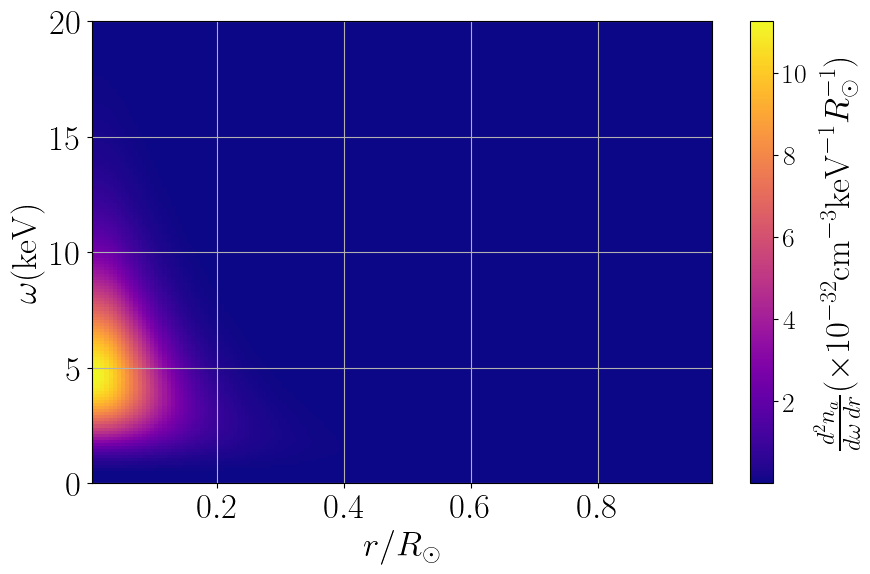

In [91]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm
import matplotlib as mpl
# Exporting the table to a DAT file
#np.savetxt('dndEdt_values_AGSS09.dat', dndEdt_values)

# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 25,   # Custom label size
    "xtick.labelsize": 25,  # Custom x-axis tick label size
    "ytick.labelsize": 25,  # Custom y-axis tick label size
    "legend.fontsize": 25,  # Custom legend font size
})


# Plotting
plt.figure(figsize=(10, 6))

# Smooth density plot
norm = mpl.colors.Normalize(vmin=dndEdt_values.max()*1.e-5, vmax=dndEdt_values.max())
plt.imshow(dndEdt_values, cmap='plasma', origin='lower', aspect='auto', extent=[r_values.min(), r_values.max(), omega_values.min(), omega_values.max()], norm=norm)
cbar = plt.colorbar(label=r'$\frac{d^{2} n_{a}}{d\omega\, dr}(\times 10^{-32}{\rm cm}^{-3}{\rm keV}^{-1}R_{\odot}^{-1})$')
cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure integer ticks on colorbar
cbar.ax.tick_params(labelsize=20)  # Custom legend tick label size
plt.xlabel(r'$r/R_{\odot}$')
plt.ylabel(r'$\omega ({\rm keV})$')
plt.grid(True)
# Save the plot as PDF
plt.savefig('sun_density_plot.pdf', bbox_inches='tight')
plt.show()

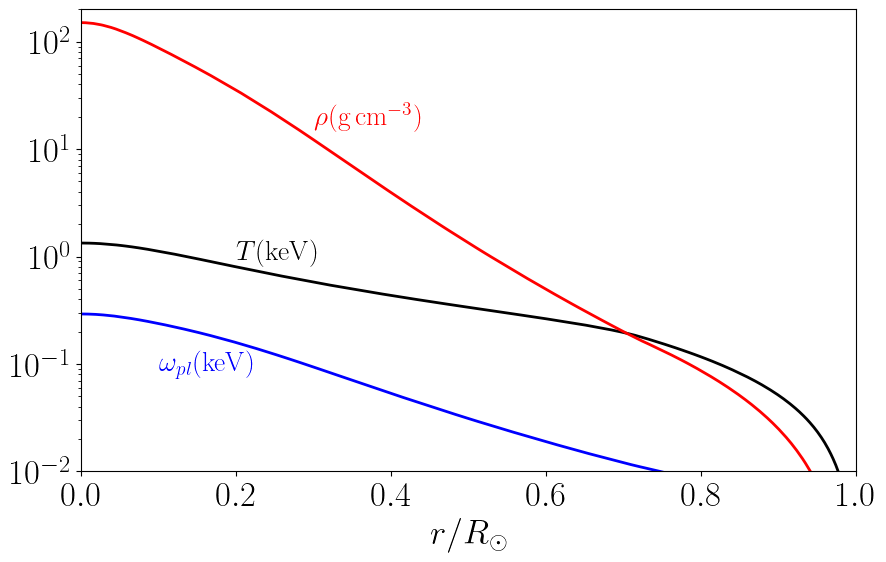

In [157]:
def prepare_interpolating_functions(url):
    table_data = read_table_from_url(url)
    if table_data is None:
        print("Failed to retrieve table data from the provided URL:", url)
        return None

    table_data = table_data[11:1968]  # Remove header
    table_data = np.array(table_data, dtype=float)

    radius = table_data[:, 1]
    temperature = table_data[:, 2]
    density = table_data[:, 3]

    temperature = temperature * 0.862e-7 #keV

    element_mass_fractions = [table_data[:, i] for i in range(6, table_data.shape[1])]
    element_interp_funcs = [interp1d(radius, mass_fraction, kind='linear') for mass_fraction in element_mass_fractions]

    return radius, temperature, density, element_interp_funcs

# URLs for different solar models
urls = [
    "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09.dat",
    "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_gs98.dat",
    "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_agss09ph.dat",
    "https://wwwmpa.mpa-garching.mpg.de/~aldos/SSM/AGSS09/model_ags05.dat"
]

interpolating_functions = {}

for url in urls:
    model_name = url.split("/")[-1].split(".")[0]
    interpolating_functions[model_name] = prepare_interpolating_functions(url)

# Example usage:
# radius_agss09, temperature_agss09, density_agss09, element_interp_funcs_agss09 = interpolating_functions["model_agss09"]
# Similarly, access other models by their names.



# Generate data for plotting
r_values = np.linspace(table_data[:, 1].min(), table_data[:, 1].max(), 100)
radius_agss09, temperature_agss09, density_agss09, element_interp_funcs_agss09 = interpolating_functions["model_agss09"]
radius_gs98, temperature_gs98, density_gs98, element_interp_funcs_gs98 = interpolating_functions["model_gs98"]
radius_agss09ph, temperature_agss09ph, density_agss09ph, element_interp_funcs_agss09ph = interpolating_functions["model_agss09ph"]
radius_ags05, temperature_ags05, density_ags05, element_interp_funcs_ags05 = interpolating_functions["model_ags05"]


# Enable LaTeX rendering
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.labelsize": 25,   # Custom label size
    "xtick.labelsize": 25,  # Custom x-axis tick label size
    "ytick.labelsize": 25,  # Custom y-axis tick label size
    "legend.fontsize": 20,  # Custom legend font size
})

plt.figure(figsize=(10, 6)) 

# Plot temperature
plt.plot(radius_agss09, temperature_agss09, color='black', linewidth=2)
plt.text(0.2, 1.1, r'$T(\mathrm{keV})$', verticalalignment='center', fontsize=20, color='black')

# Plot density
plt.plot(radius_agss09, density_agss09, color='red', linewidth=2)
plt.text(0.3,20, r'$\rho(\mathrm{g\,cm^{-3}})$', verticalalignment='center', fontsize=20, color='red')

# Plot pl frequency
plt.plot(radius_agss09, omega_p(radius_agss09), color='blue', linewidth=2)
plt.text(0.1,0.1, r'$\omega_{pl}(\mathrm{keV})$', verticalalignment='center', fontsize=20, color='blue')

# Customize the range of the plot
plt.xlim(0, 1)  # Custom x-axis limits
plt.ylim(1.e-2, 2.e2)  # Custom y-axis limits

plt.xlabel(r'$r/R_{\odot}$')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.grid(False)

# Save the plot as PDF
plt.savefig('multiple_functions_plot.pdf', bbox_inches='tight')
plt.show()

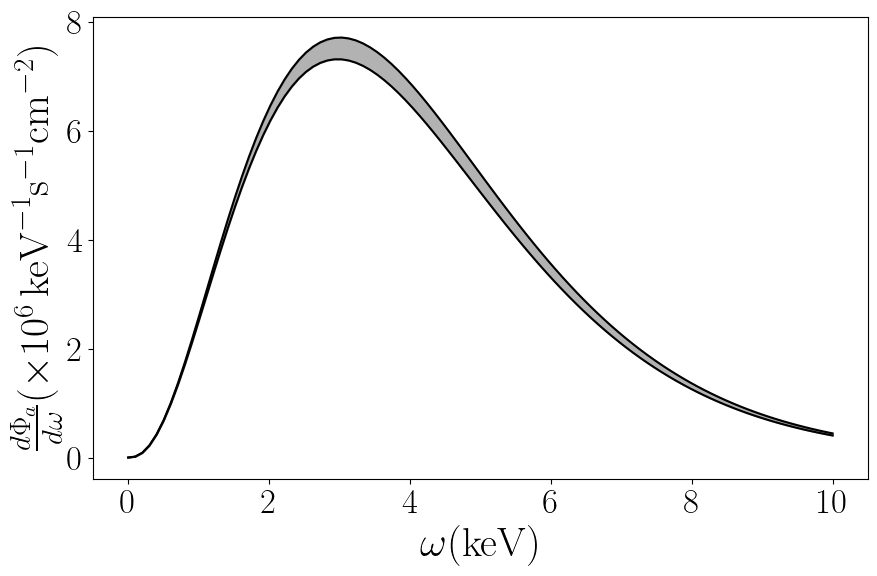

In [176]:
# Define the axion flux function
def axion_flux(E, C0, ga_gamma, E0, beta):
    return C0 * (ga_gamma / 1e-12)**2 * (E / E0)**beta * np.exp(-(1 + beta) * E / E0)
plt.figure(figsize=(10, 6))
# Parameters
C0 = (2.1923-0.0774)*1.e8  # keV^{-1} s^{-1} cm^{-2}
ga_gamma = 1.e-12  # Let's assume a value of 1 for demonstration
E0 = (4.1727-0.0164) # keV
beta = (2.5307-0.0084)

# Energy range
E_values = np.linspace(0, 10, 100)  # Energy values from 0 to 10 keV

# Compute axion flux
flux1 = axion_flux(E_values, C0, ga_gamma, E0, beta)*1.e-6

# Plot the axion flux
plt.plot(E_values, flux1, color='black')

# Parameters
C0 = (2.1923+0.0774)*1.e8  # keV^{-1} s^{-1} cm^{-2}
ga_gamma = 1.e-12  # Let's assume a value of 1 for demonstration
E0 = (4.1727+0.0164) # keV
beta = (2.5307+0.0084)



# Compute axion flux
flux2 = axion_flux(E_values, C0, ga_gamma, E0, beta)*1.e-6

# Plot the axion flux
plt.plot(E_values, flux2, color='black')

# Add labels and legend
plt.xlabel(r'$\omega({\rm keV})$', fontsize=30)
plt.ylabel(r'$\frac{d\Phi_{a}}{d\omega}(\times10^{6}\,{\rm keV}^{-1}{\rm s}^{-1}{\rm cm}^{-2})$', fontsize=30)
plt.grid(False)
# Fill between the curves
plt.fill_between(E_values, flux1, flux2, color='black', alpha=0.3) 
# Save the plot as PDF
plt.savefig('axion_flux_plot.pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_2230/3627844913.py:33: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(dndEdt, r_min, r_max, args=(omega, ma))
/tmp/ipykernel_2230/3627844913.py:14: RuntimeWarning: overflow encountered in exp
  fomg = 1/(np.exp(omega/Tv)-1)


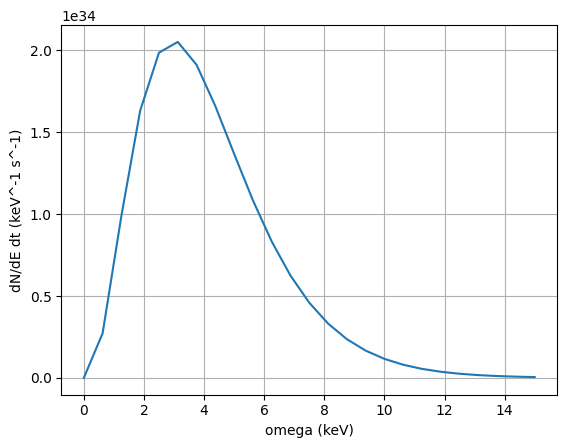

Optimized parameters: [6.05677906e+35 4.15632300e+00 2.53919645e+00]


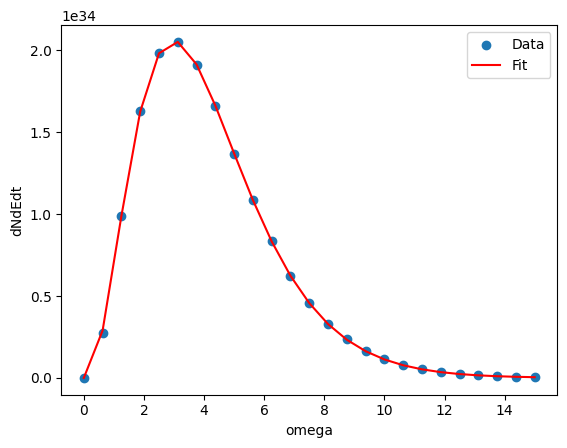

In [101]:
gag = 1.e-12 #GeV^-1
ma = 0 #keV
omega_max = 15
num_points = 25
omega_values = np.linspace(ma, omega_max, num_points) #keV

# Calculate dNdEdt for each omega value
dNdEdt_values = np.array([dNdEdt(gag, omg, ma) for omg in omega_values])

# Plot the function
plt.plot(omega_values, dNdEdt_values)
plt.xlabel('omega (keV)')
plt.ylabel('dN/dE dt (keV^-1 s^-1)')
plt.grid(True)
plt.show()

# Define your functional form
def your_function(omega, *params):
    # Your functional form here
    # Example:
    return params[0] * ((omega/params[1])**params[2]) * np.exp(-(1+params[2]) * (omega/params[1]))

# Perform the fit
params_guess = [1.e+37, 5, 2]  # Initial guess for parameters
params_opt, params_cov = curve_fit(your_function, omega_values, dNdEdt_values, p0=params_guess)

# params_opt contains optimized parameters
# params_cov contains covariance matrix

# Print the optimized parameters
print("Optimized parameters:", params_opt)

plt.scatter(omega_values, dNdEdt_values, label='Data')
plt.plot(omega_values, your_function(omega_values, *params_opt), color='red', label='Fit')
plt.xlabel('omega')
plt.ylabel('dNdEdt')
plt.legend()
plt.show()